In [9]:
import numpy as np
import scipy
import scipy.optimize as opt
import scipy.linalg as la
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import MultipleLocator

In [10]:
#set exogeneous varaibles
#assume each period is 20 years

beta = 0.442
delta = 0.6415
sigma = 3
A = 1
alpha = 0.35
nvec = np.array([1,1,0.2])
L = nvec.sum()
SS_tol = 1e-8

params = (beta, sigma, nvec, L, A, alpha, delta, SS_tol)

f_params = (nvec, A, alpha, delta)



In [11]:
def utility(consumption, params):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    return (consumption**(1-sigma) - 1)/(1 - sigma)

def u_prime(consumption, params):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    return consumption ** (-sigma)

def production(agg_capital, params):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    return A * (agg_capital ** alpha) * (L ** (1-alpha))


'''steady state ONLY'''
def get_w_bar(b2bar, b3bar, params):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    return (1-alpha) * A * ((b2bar + b3bar)/2.2)**alpha

def get_r_bar(b2bar, b3bar, params):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    return alpha * A * (2.2/(b2bar+b3bar))**(1-alpha) - delta

def euler_funcs(b_vec, params):
    b2bar = b_vec[0]
    b3bar = b_vec[1]
    w_bar = get_w_bar(b2bar, b3bar, params)
    r_bar = get_r_bar(b2bar, b3bar, params)
    result1 = u_prime(w_bar - b2bar, params) - beta * (1 + r_bar) * u_prime(w_bar + (1+r_bar) * b2bar - b3bar, params)
    result2 = u_prime(w_bar + (1+r_bar)*b2bar - b3bar, params) - beta * (1+r_bar) * u_prime((1+r_bar)*b3bar + 0.2 * w_bar, params)
    return [result1, result2]

def get_c_bar(b2bar, b3bar, params, w_bar, r_bar):
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    c1bar = w_bar * nvec[0] - b2bar
    c2bar = w_bar * nvec[1] + (1 + r_bar) * b2bar - b3bar
    c3bar = w_bar * 0.2 + (1 + r_bar) * b3bar
    return np.array([c1bar, c2bar, c3bar])



In [12]:
def feasible(f_params, bvec_guess):
    b2 = bvec_guess[0]
    b3 = bvec_guess[1]
    K_value = bvec_guess.sum()
    
    if K_value < 0:
        K_cnstr = True
    else:
        K_cnstr = False
    
    r_guess = get_r_bar(b2, b3, params)
    w_guess = get_w_bar(b2, b3, params)
    c_guess = get_c_bar(b2, b3, params, w_guess, r_guess)
    c_cnstr = [False, False, False]
    for i in range(3):
        if c_guess[i]<0:
            c_cnstr[i] = True
    b_cnstr = [False, False]
    if c_cnstr[0]:
        b_cnstr[0]=True
    if c_cnstr[1]:
        b_cnstr[0]=True
        b_cnstr[1]=True
    if c_cnstr[2]:
        b_cnstr[1]=True
    return b_cnstr, c_cnstr, K_cnstr

bg1 = np.array([1.0, 1.2])
print(feasible(f_params, bg1))
print("The first period consumption is negative.")
bg2 = np.array([0.06, -0.001])
print(feasible(f_params, bg2))
print("All good")
bg3 = np.array([0.1, 0.1])
print(feasible(f_params, bg3))
print("All good")

([True, False], [True, False, False], False)
The first period consumption is negative.
([False, False], [False, False, False], False)
All good
([False, False], [False, False, False], False)
All good


Steady state has been found.


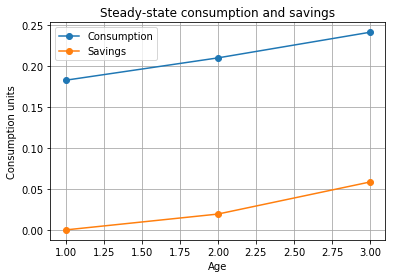

Savings in each period:        [0.01931253 0.0584111  0.        ]
Total savings/capital:         0.07772362575316386
Total production:              0.6827603788602411
Consumption in each period:    [0.18241213 0.20961468 0.24087387]
Total consumption:             0.6329006729395864
Wage in each period:           0.20172465739052575
Interest rate in each period:  2.433062339127069
Error in euler equation:       [-1.39266376e-12  2.62900812e-12]
Error in resource constraint:  8.326672684688674e-17
Running time:                  0.23491699999999982


In [13]:
def get_SS(params, bvec_guess, ss_graphs):
    start_time = time.clock()
    
    par = list(params)
    SS_tol = par[-1]
    soln = opt.root(euler_funcs, bvec_guess, args = par, tol = SS_tol)
    if soln.success:
        print("Steady state has been found.")
        bvec_ss = np.array(soln.x)
        K_ss = bvec_ss.sum()
        w_ss = get_w_bar(bvec_ss[0], bvec_ss[1], params)
        r_ss = get_r_bar(bvec_ss[0], bvec_ss[1], params)
        Y_ss = production(K_ss, params)
        cvec_ss = get_c_bar(bvec_ss[0], bvec_ss[1], params, w_ss, r_ss)
        #C_ss it total consumption
        C_ss = cvec_ss.sum()
        
        #euler errors
        euler_err1 = u_prime(w_ss - bvec_ss[0], params) - beta * (1 + r_ss) * u_prime(w_ss + (1+r_ss) * bvec_ss[0] - bvec_ss[1], params)
        euler_err2 = u_prime(w_ss + (1+r_ss)*bvec_ss[0] - bvec_ss[1], params) - beta * (1+r_ss) * u_prime((1+r_ss)*bvec_ss[1] + 0.2 * w_ss, params)
        EulErr_ss = np.array([euler_err1, euler_err2])
        RCerr_ss = Y_ss - C_ss - params[6]*K_ss
        
        if ss_graphs:
            age = np.arange(1, 4)
            fig, ax = plt.subplots()
            plt.plot(age, cvec_ss, marker='o', label='Consumption')
            plt.plot(age, np.append([0], bvec_ss), marker='o', label='Savings')

            minorLocator = MultipleLocator(1)
            ax.xaxis.set_minor_locator(minorLocator)
            plt.grid(b=True, which='major', color='0.65', linestyle='-')
            plt.title('Steady-state consumption and savings')
            plt.xlabel('Age')
            plt.ylabel('Consumption units')
            plt.legend()
            plt.show()
        
        end_time = time.clock()
        ss_time = end_time - start_time
        
        ss_output = {
            "b_ss": bvec_ss, "c_ss": cvec_ss, "w_ss": w_ss, "r_ss": r_ss, "K_ss": K_ss, "Y_ss": Y_ss, "C_ss": C_ss,
            "Euler_ss": EulErr_ss, "RCerr_ss": RCerr_ss, "ss_time": ss_time}
        
        print("Savings in each period:       ", np.append(bvec_ss, [0]))
        print("Total savings/capital:        ", K_ss)
        print("Total production:             ", Y_ss)
        print("Consumption in each period:   ", cvec_ss)
        print("Total consumption:            ", C_ss)
        print("Wage in each period:          ", w_ss)
        print("Interest rate in each period: ", r_ss)
        print("Error in euler equation:      ", EulErr_ss)
        print("Error in resource constraint: ", RCerr_ss)
        print("Running time:                 ", ss_time)
        return ss_output
    else:
        raise ValueError("Steady State Not Found")

ss_output = get_SS(params, [0.1,0.1], True)

In [19]:
def get_w_t(K_t):
    return (1-alpha) * A * (K_t / 2.2) ** alpha

def get_r_t(K_t):
    return alpha * A * (2.2/K_t) ** (1-alpha) - delta

T = 50 
epsilon = 1e-9                   
xi = 0.3
nvec = np.array([1, 1, 0.2])
# tolerance for Euler errors
eul_tol = 1e-6                
max_iter = 10000
#params = [beta, sigma, nvec, L, A, alpha, delta, eul_tol, max_iter]

b2bar = ss_output['b_ss'][0]
b3bar = ss_output['b_ss'][1]

b_ss = np.array([b2bar, b3bar])
b2_1 = 0.8 * b2bar
b3_1 = 1.1 * b3bar
bvec_guess = np.array([b2_1, b3_1])

K_1 = b2_1 + b3_1
K_bar = b2bar + b3bar
K_path = np.linspace(K_1, K_bar, T)
#suppose T+1 period we return to steady state
K_path = np.append(K_path, K_bar)

def get_r_and_w_paths(K_path, K_bar):
    
    r_path = get_r_t(K_path)
    #r_path = np.append(r_path, get_r_t(K_bar))
    
    w_path = get_w_t(K_path)
    #w_path = np.append(w_path, get_w_t(K_bar))
    
    return np.array([r_path, w_path])

r_path, w_path = get_r_and_w_paths(K_path, K_bar)
r_path

def EulErr_b3_2(b3_2, args_32):
    ### args_32 = [b2_1, b2_2, r_path, w_path]
    
    b2_1 = args_32[0]
    b2_2 = args_32[1]
    r_path = args_32[2]
    w_path = args_32[3]
    
    mu1 = u_prime((1 + r_path[0]) * b2_1 + w_path[0] * 1 - b3_2, params)
    mu2 = u_prime((1 + r_path[1]) * b3_2 + w_path[1] * 0.2, params)
    
    EulErr = mu1 - beta * (1 + r_path[1]) * mu2
    
    return EulErr

def EulErr_two_b_s(b_vec, args_2):
    #args_2 = [t, r_path, w_path]
    t = args_2[0]
    r_path = args_2[1]
    w_path = args_2[2]
    
    mu2_1 = u_prime(w_path[t] * 1 - b_vec[0], params)
    mu2_2 = u_prime((1 + r_path[t+1]) * b_vec[0] + w_path[t+1] * 1 - b_vec[1], params)
    EulErr2 = mu2_1 - beta * (1 + r_path[t+1]) * mu2_2
    
    
    mu3_1 = u_prime((1 + r_path[t+1]) * b_vec[0] + w_path[t+1] * 1 - b_vec[1], params)
    mu3_2 = u_prime((1 + r_path[t+2]) * b_vec[1] + w_path[t+2] * 0.2, params)
    EulErr3 = mu3_1 - beta * (1 + r_path[t+2]) * mu3_2
    
    return np.array([EulErr2, EulErr3])


# Solve for b32, return error
def b3_2_solver(b2_1, b2_2, r_path, w_path):
    
    args_32 = [b2_1, b2_2, r_path, w_path]
    
    soln = opt.root(EulErr_b3_2, 0.05, args = args_32, tol = eul_tol)
    b3_2 = soln.x
    b3_2_EulErrs = soln.fun
    
    return np.array([b3_2, b3_2_EulErrs])

def two_b_solver(t, r_path, w_path):
    args_2 = [t, r_path, w_path]
    
    soln = opt.root(EulErr_two_b_s, [0.05, 0.05], args = args_2, tol = eul_tol)
    b_vec = soln.x
    b_EulErrs = soln.fun
    
    return np.array([b_vec, b_EulErrs])



def aggregate_errs(K_path, r_path, w_path, b_mat):
    
    L = 2.2
    
    C = L * w_path[:-1] + (1 + r_path[:-1]) * b_mat[:-1,0] - b_mat[1:,0] + (1 + r_path[:-1]) * b_mat[:-1,1] - b_mat[1:,1]
    Y = params[4] * (K_path[:-1]**alpha) * L**(1 - alpha)
    
    agg_err = Y - C - K_path[1:] + (1 - delta) * K_path[:-1]
    max_agg_err = np.abs(agg_err).max()
    
    return max_agg_err


def computeEachPath(T, r_path, w_path, K_path):
    
    b_mat = np.zeros((T+1,2))
    b_mat[0,:] = bvec_guess
    
    Euler_errs = np.zeros((T+1,2))
    
    b_mat[1,1], Euler_errs[1,1] = b3_2_solver(b_mat[0,0], b_mat[0,1], r_path, w_path)
    
    for i in range(T-1):
        b_mat[[i+1, i+2], [0,1]], Euler_errs[[i+1, i+2], [0,1]] = two_b_solver(i, r_path, w_path)
     
    agg_errs = aggregate_errs(K_path, r_path, w_path, b_mat)
    max_Euler_errs = np.abs(Euler_errs).max(axis = 0)
    
    
    return b_mat, max_Euler_errs, agg_errs


    
    

In [20]:
difference = 1
currentItr = 0
while (difference > epsilon) and currentItr < max_iter:
    
    r_path, w_path = get_r_and_w_paths(K_path, K_bar)
    
    b_mat, max_EulErrs, max_agg_errs = computeEachPath(T, r_path, w_path, K_path)
    
    K_prime = b_mat[:-1,:].sum(axis = 1)
    K_prime = np.append(K_prime, K_bar)
    difference = la.norm(K_prime - K_path)
    K_path = xi * K_prime + (1 - xi) * K_path
    currentItr += 1
    
    


print('Max Euler error for generation 2 is: ', max_EulErrs[0])
print('Max Euler error for generation 3 is: ', max_EulErrs[1])
print('Max constraint error is:', max_agg_errs)

print(b_mat)

Max Euler error for generation 2 is:  1.0690769158827607e-08
Max Euler error for generation 3 is:  9.627906649711804e-08
Max constraint error is: 0.01931252950594873
[[0.01545002 0.06425221]
 [0.02038156 0.05499108]
 [0.01862165 0.05910848]
 [0.01943457 0.05773015]
 [0.01917321 0.05844195]
 [0.01931411 0.05825579]
 [0.01927989 0.05838781]
 [0.01930648 0.05836978]
 [0.01930362 0.05839746]
 [0.01930935 0.05839864]
 [0.0193098  0.05840542]
 [0.01931124 0.05840704]
 [0.01931163 0.05840896]
 [0.01931205 0.05840971]
 [0.01931222 0.05841032]
 [0.01931236 0.05841062]
 [0.01931242 0.05841082]
 [0.01931247 0.05841093]
 [0.01931249 0.058411  ]
 [0.01931251 0.05841104]
 [0.01931252 0.05841106]
 [0.01931252 0.05841108]
 [0.01931253 0.05841108]
 [0.01931253 0.05841109]
 [0.01931253 0.05841109]
 [0.01931253 0.05841109]
 [0.01931253 0.05841109]
 [0.01931253 0.0584111 ]
 [0.01931253 0.0584111 ]
 [0.01931253 0.0584111 ]
 [0.01931253 0.0584111 ]
 [0.01931253 0.0584111 ]
 [0.01931253 0.0584111 ]
 [0.01931

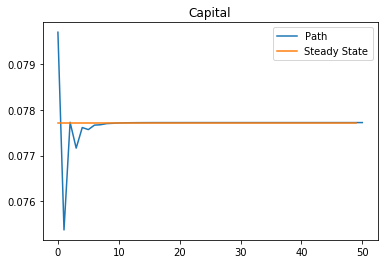

In [21]:
plt.plot(K_path, label = "Path")
plt.title("Capital")
plt.plot(np.arange(0,50), [K_bar]*50, label = "Steady State")
plt.legend()
plt.show()

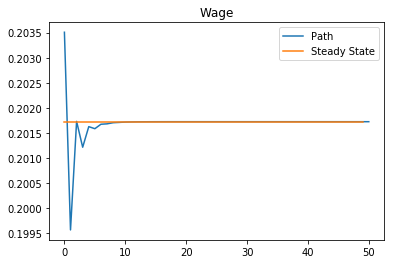

In [23]:
plt.plot(w_path, label = "Path")
plt.plot(np.arange(50),[ss_output["w_ss"]]*50, label = "Steady State")
plt.title("Wage")
plt.legend()
plt.show()

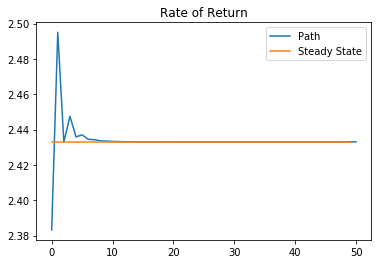

In [24]:
plt.plot(r_path, label = "Path")
plt.plot(np.arange(50),[ss_output["r_ss"]]*50, label = "Steady State")
plt.title("Rate of Return")
plt.legend()
plt.show()

In [25]:
error = K_path - K_bar
loc = np.where(np.abs(error) < 0.00001)
loc

(array([ 2, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 45, 46, 47, 48, 49, 50]),)

In [26]:
print("Observe that in period 2 the economy first gets within 0.00001 of the steady state.")
print("After 10 periods, the economy stays within this margin of error")

Observe that in period 2 the economy first gets within 0.00001 of the steady state.
After 10 periods, the economy stays within this margin of error
